In [1]:
import h5py
import psana
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import  rotate
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit,minimize
from scipy import signal
import multiprocessing
import os
from functools import partial
import time
import sys
import argparse
from datetime import datetime
import tempfile
import XSpect.XSpect_Analysis
import XSpect.XSpect_Controller
import XSpect.XSpect_Visualization
from XSpect.XSpect_Processor import Peaks
from XSpect.XSpect_Processor import Background
from matplotlib.patches import Patch
import pickle


## Viewing Static XES Spectra 

Processing: 100%|██████████| 9/9 [00:17<00:00,  1.94s/Shot_Batch]


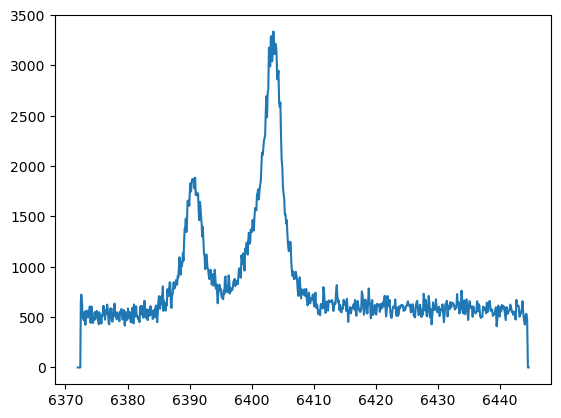

In [27]:
##do not change

xes_experiment = XSpect.XSpect_Analysis.spectroscopy_experiment(hutch='mfx',experiment_id='mfxl1033223',lcls_run=23)
xes=XSpect.XSpect_Controller.XESBatchAnalysisRotation()
keys=['ipm_dg2/sum'] 
names=['ipm']
xes.set_key_aliases(keys,names)
xes.transpose=True
xes.pixels_to_patch=[382,383,384,385]#needed to change since detector is 90 degrees from standard. e.g. transposed above
xes.patch_mode='polynomial'

## end do not change

#Set epix detector here
xes.key_epix=['epix_1/ROI_0_area'] #Uncomment this for additional detector.
xes.hitfind=True
#xes.import_roi=[[0,-1]]
xes.rois=[[48,61]] #set this ROI and iterate with the full detector image in the next cell.

#remove this filter if measuring with attenuating beam e.g. with foil.
xes.add_filter('xray','ipm',1.0E3)
##

xes.adu_cutoff=3.0
xes.angle=2


xes.run_parser(['665-667']) 
start=time.time()
xes.primary_analysis_parallel_range(4,xes_experiment,method=xes.primary_analysis_static,increment=2000,verbose=False)
end=time.time()
v=XSpect.XSpect_Visualization.XESVisualization()
v.combine_static_spectra(xes_analysis=xes,xes_key='epix_ROI_1')
v.make_energy_axis(A=41.25, R=250,  mm_per_pixel=0.05, d=0.981)
#v.make_energy_axis(A=67.78, R=250,mm_per_pixel=0.05, d=0.859)
plt.plot(v.energy,v.summed_xes)
xes.aggregate_statistics()



## View the detector image and verify the angle that we applied is good and the ROI is good. 

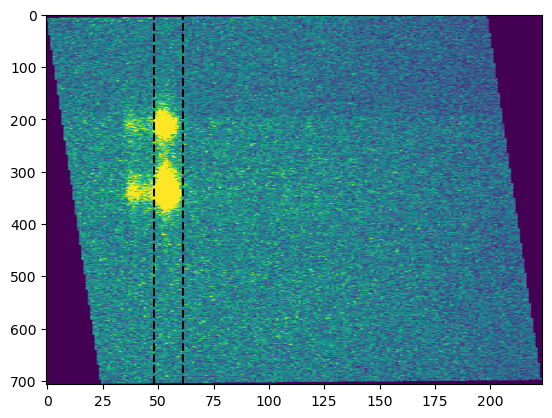

In [45]:
xes.analyzed_runs[0].epix
v.combine_static_spectra(xes_analysis=xes,xes_key='epix')
v.summed_xes.shape
vmin, vmax = np.percentile(v.summed_xes, [1,99])
plt.imshow(v.summed_xes,vmin = vmin, vmax = vmax, aspect='auto')
for i in xes.rois[0]:
    plt.axvline(i,color='k',linestyle='--')

## Here we fit the background polyomial and from that calcualte the FWHM of the Ka1 and First moment.
## Look at the plot and verify the pink exclusion zones are indeed excluding the spectral signal and any strange detector edge artifacts.
## The dashed lines indicate where the FWHM will be calculated.

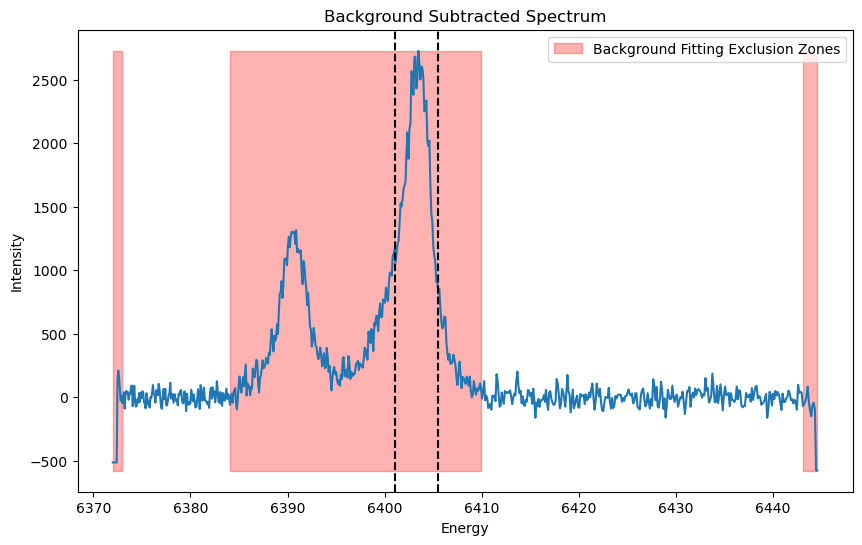

In [59]:
v.combine_static_spectra(xes_analysis=xes,xes_key='epix_ROI_1')
exclusions= (
    (6360, 6373), #edge of detector
    (6384, 6410),
    # (7457,7485), #Main peaks
    (6443,6450),# other edge of detector
)
v.background_subtracted=Background.polynomial_subtraction(v.energy,v.summed_xes,4,exclusions)

 
  
plt.figure(figsize=(10, 6))
plt.plot(v.energy, v.background_subtracted, label='Background Subtracted')
plt.xlabel('Energy')
plt.ylabel('Intensity')
plt.title('Background Subtracted Spectrum')

for (x_start, x_end) in exclusions:
    plt.fill_between(v.energy, min(v.background_subtracted) - 1, max(v.background_subtracted) + 1, 
                     where=((v.energy >= x_start) & (v.energy <= x_end)), color='red', alpha=0.3)


exclusion_patch = Patch(color='red', alpha=0.3, label='Background Fitting Exclusion Zones')
plt.legend(handles=[exclusion_patch], loc='upper right')
fwhm_range=[6401.1,6405.5]
for i in fwhm_range:
    plt.axvline(i,color='k',linestyle='--')
#plt.xlim(6395,6410)
plt.show()
xes.first_moment=Peaks.first_moment(v.energy,v.background_subtracted,6398,6408)
xes.popt=Peaks.gaussian_fwhm(v.energy,v.background_subtracted,fwhm_range[0],fwhm_range[1],all_vals=True)
#print(xes.first_moment,xes.fwhm)


## Here we plot the fitted gaussian to verify it is somewhat reasonable with the spectrum. If it is not then modify fwhm_range in the previous cell.

(6395.0, 6410.0)

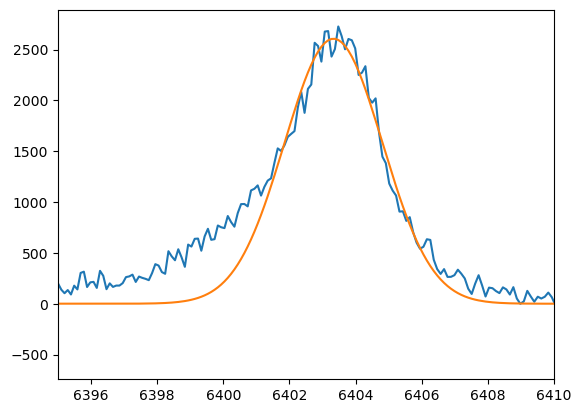

In [60]:
plt.plot(v.energy, v.background_subtracted, label='Background Subtracted')
plt.plot(v.energy, Peaks.gaussian(v.energy,*xes.popt))
plt.xlim(6395,6410)

## Here we perform the first moment and FWHM calculation on the normalized background subtracted data.

6402.891129764138 3.7120191764253496


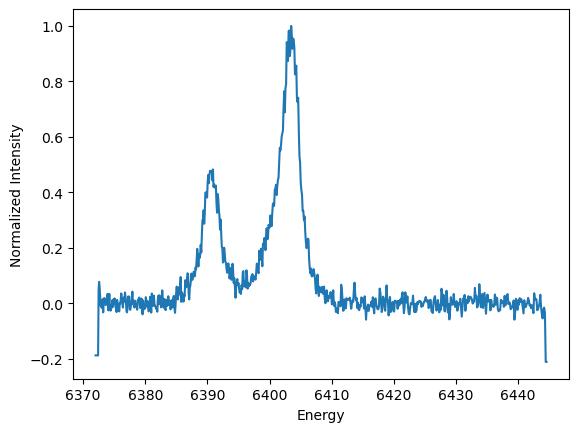

In [61]:
#First moment calculated after maximum peak normalized to 1
v.normalize_peak(6386,6418)
xes.first_moment=Peaks.first_moment(v.energy,v.normalized_peak,6398,6408)
xes.fwhm=Peaks.gaussian_fwhm(v.energy,v.normalized_peak,6401,6405)
plt.plot(v.energy,v.normalized_peak)
plt.xlabel('Energy')
plt.ylabel('Normalized Intensity')
print(xes.first_moment,xes.fwhm)

## Here we apply Savitzky-Golay smoothing to the normalized specta and dump the analyzed data and visualization steps (aggregation, normalization, etc) into .pkl files.

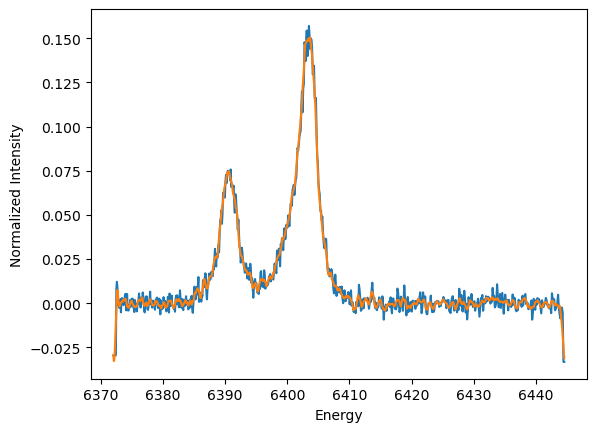

In [62]:
v.smoothed = signal.savgol_filter(v.normalized, window_length=10, polyorder=2, mode="nearest")
plt.plot(v.energy,v.normalized)
plt.plot(v.energy,v.smoothed)
plt.xlabel('Energy')
plt.ylabel('Normalized Intensity')

#Pickles data and analysis files based on above code
with open(f'data_{str(xes.runs)}.pkl', 'wb') as f:
    pickle.dump(xes, f)
with open(f'analysis_{str(xes.runs)}.pkl', 'wb') as f:
    pickle.dump(v, f)

## Printing statistics here to verify that XES hit finding seems reasonable. It should be close to the crystal hit finding percents.

In [63]:
print(f'First Moment: {xes.first_moment}')
print(f'FWHM: {xes.fwhm}')
xes.print_run_statistics()

First Moment: 6402.891129764138
FWHM: 3.7120191764253496
Run Number: 665
  Total: 4426
  X-ray Total: 4426
  Laser Total: 4426
  XES_Hits: 1303
  Percent_XES_Hits: 29.44%

Run Number: 666
  Total: 8996
  X-ray Total: 8996
  Laser Total: 8996
  XES_Hits: 5068
  Percent_XES_Hits: 56.34%

Run Number: 667
  Total: 1816
  X-ray Total: 1816
  Laser Total: 1816
  XES_Hits: 1232
  Percent_XES_Hits: 67.84%



## Below this is for troubleshooting some hit finding issues. Probably don't run the cells below.


In [56]:
xes.analyzed_runs[0].status

['New analysis of run 665 located in: /sdf/data/lcls/ds/mfx/mfxl1033223/hdf5/smalldata/mfxl1033223_Run0665.h5',
 'HDF5 import of keys completed. Time: 0.00 seconds',
 'HDF5 import of keys completed. Time: 0.83 seconds',
 'Obtained shot properties',
 'Shots combined for detector epix on filters: xray and xray into epix',
 'Key: epix has been adu filtered by threshold: 3.000000',
 'Mask: xray has been filtered on ipm by minimum threshold: 1000.000\nShots removed: 75',
 'Starting hit finding',
 'Hit finding on epix. Hits found: 788, median: 764.79407, std: 436.14190673828125, threshold: 328.65216064453125',
 'Applying Hits to ePix detector. New size 788',
 'Reduced detector by shots: epix with number of shots: (788, 200, 700)',
 'Detector epix pixel 382 patched. Old value.',
 'Detector epix pixel 383 patched. Old value.',
 'Detector epix pixel 384 patched. Old value.',
 'Detector epix pixel 385 patched. Old value.',
 'Spatially reduced detector: epix with combined ROI indices: 48-61']

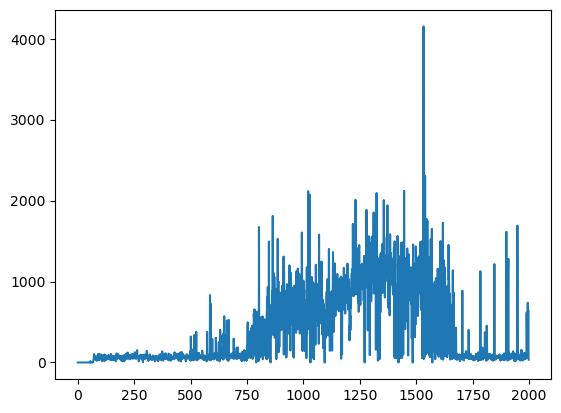

In [57]:
plt.plot(xes.analyzed_runs[0].sum_images)

In [14]:
sum_images=xes.analyzed_runs[0].sum_images
absolute_threshold=1000
cutoff_multiplier=1
hit_indices=[]
if absolute_threshold is not None:
    hits = sum_images > absolute_threshold
    hit_indices.extend(np.where(hits)[0])

if cutoff_multiplier is not None:
    mean_sum = np.median(sum_images)
    std_sum = np.std(sum_images)
    threshold = mean_sum - cutoff_multiplier * std_sum
    hits = sum_images > threshold
    hit_indices.extend(np.where(hits)[0])
else:
    mean_sum = None
    std_sum = None
    threshold = None

# Removing any duplicate indices
hit_indices = np.unique(hit_indices)

In [15]:
np.where(sum_images > absolute_threshold)[0]

array([ 803,  847,  864,  867,  871,  886,  889,  912,  914,  938,  943,
        944,  969,  975,  981,  989,  993, 1000, 1015, 1021, 1024, 1028,
       1037, 1055, 1069, 1080, 1107, 1113, 1131, 1139, 1150, 1156, 1160,
       1166, 1173, 1179, 1181, 1182, 1186, 1195, 1197, 1201, 1213, 1214,
       1217, 1219, 1220, 1224, 1225, 1226, 1229, 1230, 1231, 1232, 1235,
       1236, 1239, 1244, 1247, 1249, 1250, 1251, 1254, 1255, 1259, 1260,
       1261, 1264, 1265, 1269, 1272, 1274, 1275, 1276, 1277, 1278, 1279,
       1280, 1281, 1283, 1284, 1286, 1287, 1289, 1290, 1293, 1295, 1296,
       1297, 1298, 1299, 1302, 1303, 1304, 1306, 1307, 1308, 1309, 1310,
       1311, 1313, 1314, 1315, 1316, 1317, 1320, 1322, 1324, 1326, 1331,
       1333, 1335, 1336, 1339, 1342, 1343, 1344, 1345, 1346, 1347, 1348,
       1349, 1351, 1352, 1353, 1354, 1356, 1358, 1360, 1362, 1363, 1364,
       1365, 1366, 1367, 1368, 1369, 1370, 1371, 1372, 1374, 1378, 1379,
       1380, 1384, 1385, 1386, 1387, 1388, 1389, 13

In [16]:
#xes.run_parser(['77-89','91-92']) #Red
#xes.run_parser(['93-99','101-102','105-109']) #2s
#xes.run_parser(['112-114','116-117','121-125','128-132']) #1s
with open(f'data_{str(xes.runs)}.pkl', 'rb') as f:
    data_AlkB_O2_2s = pickle.load(f)
   
with open(f'analysis_{str(xes.runs)}.pkl', 'rb') as f:
    analysis_AlkB_O2_2s = pickle.load(f)

In [17]:
plt.plot(analysis_AlkB_Red.energy,analysis_AlkB_Red.normalized)
plt.plot(analysis_AlkB_O2_1s.energy,analysis_AlkB_O2_1s.normalized)
plt.plot(analysis_AlkB_O2_2s.energy,analysis_AlkB_O2_2s.normalized)



NameError: name 'analysis_AlkB_Red' is not defined

In [ ]:
print('Red','1s','2s')
print(data_AlkB_Red.fwhm,data_AlkB_O2_1s.fwhm,data_AlkB_O2_2s.fwhm)
print(data_AlkB_Red.first_moment,data_AlkB_O2_1s.first_moment,data_AlkB_O2_2s.first_moment)

In [ ]:
plt.plot(analysis_AlkB_Red.energy[70:500],analysis_AlkB_Red.normalized[70:500])
plt.plot(analysis_AlkB_O2_1s.energy[70:500],analysis_AlkB_O2_1s.normalized[70:500])
plt.plot(analysis_AlkB_O2_2s.energy[70:500],analysis_AlkB_O2_2s.normalized[70:500])

In [ ]:
xes_experiment = XSpect.XSpect_Analysis.spectroscopy_experiment(hutch='mfx',experiment_id='mfxl1027922',lcls_run=22)
xes=XSpect.XSpect_Controller.XESBatchAnalysisRotation()
keys=['ipm_dg2/sum'] 
names=['ipm']
xes.set_key_aliases(keys,names)
xes.hitfind=True
#xes.import_roi=[[0,-1]]
xes.rois=[[95,110]]
xes.add_filter('xray','ipm',1.0E3)
#xes.add_filter('simultaneous','ipm4',1.0E3)
xes.adu_cutoff=3.0
xes.angle=0
xes.transpose=True
xes.pixels_to_patch=[382,383,384,385]#needed to change since detector is 90 degrees from standard. e.g. transposed above
xes.patch_mode='polynomial'
xes.run_parser(['230'])
start=time.time()
xes.primary_analysis_parallel_range(4,xes_experiment,method=xes.primary_analysis_static,increment=2000,verbose=False)
end=time.time()
v=XSpect.XSpect_Visualization.XESVisualization()
v.combine_static_spectra(xes_analysis=xes,xes_key='epix_ROI_1')
v.make_energy_axis(A=43.25, R=250,  mm_per_pixel=0.05, d=0.895)
plt.plot(v.energy,v.summed_xes)
xes.aggregate_statistics()

In [ ]:
xes.first_moment=Peaks.first_moment(v.energy,v.summed_xes,7030,7072)
xes.fwhm=Peaks.gaussian_fwhm(v.energy,v.summed_xes,7030,7072)
exclusions= (
    (6980, 6990), #edge of detector
    (7030,7070), #Main peaks
    (7076,7081),# other edge of detector
)
v.background_subtracted=Background.polynomial_subtraction(v.energy,v.summed_xes,4,exclusions)


plt.figure(figsize=(10, 6))
plt.plot(v.energy, v.background_subtracted, label='Background Subtracted')
plt.xlabel('Energy')
plt.ylabel('Intensity')
plt.title('Background Subtracted Spectrum')

for (x_start, x_end) in exclusions:
    plt.fill_between(v.energy, min(v.background_subtracted) - 1, max(v.background_subtracted) + 1, 
                     where=((v.energy >= x_start) & (v.energy <= x_end)), color='red', alpha=0.3)


exclusion_patch = Patch(color='red', alpha=0.3, label='Exclusion Zones')
plt.legend(handles=[exclusion_patch], loc='upper right')
plt.show()
with open(f'data_kb__{str(xes.runs)}.pkl', 'wb') as f:
    pickle.dump(xes, f)
with open(f'analysis_kb_{str(xes.runs)}.pkl', 'wb') as f:
    pickle.dump(v, f)

In [ ]:
v.normalize_spectrum(7030,7070)
plt.plot(v.energy,v.normalized)
plt.xlabel('Energy')
plt.ylabel('Normalized Intensity')
with open(f'data_{str(xes.runs)}.pkl', 'wb') as f:
    pickle.dump(xes, f)
with open(f'analysis_{str(xes.runs)}.pkl', 'wb') as f:
    pickle.dump(v, f)

In [ ]:
print(f'First Moment: {xes.first_moment}')
print(f'FWHM: {xes.fwhm}')
xes.print_run_statistics()